# Pre Training

## Install Dependencies

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
! pip install -q Levenshtein
! python -q -m spacy download en_core_web_trf

2023-07-15 15:10:09.637950: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 15:10:09.695559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 15:10:10.756104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.3/460.3 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import tempfile
import shutil

from keras.models import Sequential
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from sklearn.metrics import accuracy_score
from scipy import spatial
import en_core_web_sm
import Levenshtein
import nltk
import dlib
from datetime import datetime

from skimage import exposure



## Import the Data

In [ ]:
! gdown 16ievG8aYUBMbn-6_docyrPD_4bLrJqtJ

Downloading...
From: https://drive.google.com/uc?id=16ievG8aYUBMbn-6_docyrPD_4bLrJqtJ
To: /content/processed_data_with_alignments.zip
100% 639M/639M [00:06<00:00, 99.3MB/s]


In [ ]:
! unzip -q processed_data_with_alignments -d /content/data

replace /content/data/alignments/s17/lrbq1a.align? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Define Variables

In [ ]:
selected_speakers = np.arange(30, 35)

In [ ]:
invalid_speakers = [21,8,28]

In [ ]:
speakers = [speaker for speaker in range(1, 36) if speaker in selected_speakers and speaker not in invalid_speakers]

In [ ]:
print(speakers)

[30, 31, 32, 33, 34]


In [ ]:
cache_dir = '/content/data'
alignment_dir = f'{cache_dir}/alignments'
videos_dir = f'{cache_dir}/videos'

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
bad_videos = []

## Load the Data and Alignments

In [ ]:
def load_video(path):
  cap = cv2.VideoCapture(path)
  frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = []

  try:
    for _ in range(frames_count):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame)
  except:
    bad_videos.append(path)
    print("error loading video")
    raise

  cap.release()
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))

  return tf.cast((frames - mean), tf.float32) / std

In [ ]:
def load_alignment(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(video_path):
    video_path = bytes.decode(video_path.numpy())
    frames = load_video(video_path)
    alignment_path = video_path.replace("videos","alignments").replace("mp4","align")
    alignments = load_alignment(alignment_path)

    return frames, alignments

In [ ]:
def mappable_function(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Define Generic Functions

### Functions For Metrics

**`tensors_to_strings`** - A function which converts tensors to a string

In [ ]:
def tensors_to_strings(tensor_list):
    string_list = []
    for tensor in tensor_list:
        # Convert tensor to string using K.eval()
        string_value = tf.keras.backend.eval(tensor).decode('utf-8')  # Assuming UTF-8 encoding
        string_list.append(string_value)

    return string_list

**`nlp_accuracy`** - A function which calculates the accuracy using nlp

In [ ]:
def nlp_accuracy(y_true_string, y_pred_string):
  nlp = en_core_web_sm.load()
  result = 0

  for true, pred in zip(y_true_string, y_pred_string):
    true_doc, pred_doc = nlp(true).vector, nlp(pred).vector
    result += (1 - spatial.distance.cosine(true_doc, pred_doc))

  avg_accuracy = result / len(y_true_string)
  return avg_accuracy

**`levenstein_accuracy`** - A function which calculates and prints the accuracy using Levenstein

In [ ]:
def levenstein_accuracy(y_true_string, y_pred_string):
  similarity = 0

  for true, pred in zip(y_true_string, y_pred_string):
    distance = Levenshtein.distance(true, pred)
    max_length = max(len(true), len(pred))
    similarity += (1 - (distance / max_length))
    threshold = 0.8

  avg_accuracy = similarity / len(y_true_string)
  return avg_accuracy

*Wer and Cer accuracy*

**`calculate_wer`** - A function which calculates the wer accuracy for a single sentence

**`calculate_cer`** - A function which calculates the cer accuracy for a single sentence

**`wer_and_cer_accuracy`** - A function which calculates the average wer Cer accuracy

In [ ]:
def calculate_wer(reference, hypothesis):
    reference_tokens = reference.lower().split()
    hypothesis_tokens = hypothesis.lower().split()

    distance = nltk.edit_distance(reference_tokens, hypothesis_tokens)
    wer = distance / len(reference_tokens)
    return wer

def calculate_cer(reference, hypothesis):
    reference_chars = list(reference.lower())
    hypothesis_chars = list(hypothesis.lower())

    distance = nltk.edit_distance(reference_chars, hypothesis_chars)
    cer = distance / len(reference_chars)
    return cer

def wer_and_cer_accuracy(y_true_string, y_pred_string):
  wer_score, cer_score = 0, 0
  for true, pred in zip(y_true_string, y_pred_string):
    wer_score += calculate_wer(true, pred)
    cer_score += calculate_cer(true, pred)

  avg_wer = wer_score / len(y_true_string)
  avg_cer = cer_score / len(y_true_string)

  return avg_wer, avg_cer

## Create Train and Test Datasets

### Augmentation functions

In [ ]:
def apply_brightness_augmentation(frames):
    brightness_factor = np.random.uniform(0.7, 1.3)
    return frames * brightness_factor

In [ ]:
def apply_flipping_augmentation(frames):
   return tf.image.flip_left_right(frames)


### Data creation


In [ ]:
batch_size = 1
train_percentage = 0.5

data = tf.data.Dataset.list_files('./data/videos/*/*.mp4')
data_count = len(data)
print(data_count)
preprocessed_data = data.shuffle(data_count, reshuffle_each_iteration=False).map(mappable_function).prefetch(tf.data.AUTOTUNE)

train_count = int(train_percentage * data_count)
print(train_count)
# Added for split
# Batch size is 2 hard coded, bigger batch sizes caused problems
train = preprocessed_data.take(train_count).padded_batch(1, padded_shapes=([75,None,None,None],[40])).take(2)
test = preprocessed_data.skip(train_count).padded_batch(1, padded_shapes=([75,None,None,None],[40])).take(2)

30852
15426


In [ ]:
print('train', len(train), 'test', len(test))

train 2 test 2


In [ ]:
# Take an example
batch = train.as_numpy_iterator().next()
batch_videos, batch_alignments = batch
sample_video = batch_videos[0]
sample_alignments = batch_alignments[0]

# Save the example video as gif
imageio.mimsave('./animation.gif', sample_video, fps=10)

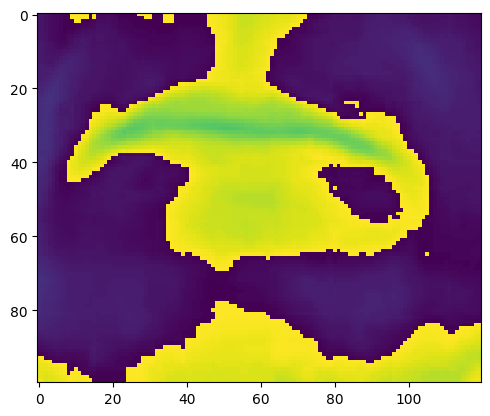

In [ ]:
# Plot an example frame of the video and the video's alignment
tf.strings.reduce_join([num_to_char(word) for word in sample_alignments])
plt.imshow(sample_video[70])

# The Model

## Define the Model Architecture

In [ ]:
input_shape = sample_video.shape
input_shape

(75, 100, 120, 1)

In [ ]:
def create_model():
  model = Sequential()
  # Three layers of 3D/spatiotemporal convolutions.
  model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPool3D((1,2,2)))

  model.add(Conv3D(256, 3, padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPool3D((1,2,2)))

  model.add(Conv3D(75, 3, padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPool3D((1,2,2)))

  # Flattens each time slice independently.
  model.add(TimeDistributed(Flatten()))

  # Two layers of Bi-LSTM's.
  # return_sequences=True makes the the network output a sequence of predictions, one for each time step of the input sequence.
  model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
  model.add(Dropout(.5))

  model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
  model.add(Dropout(.5))

  # Linear transformation (dense layer) and output (softmax layer).
  model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
  return model

In [ ]:
model_example = create_model()
model_example.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 100, 120, 128  3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 100, 120, 128  0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 50, 60, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 50, 60, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 50, 60, 256)   0         
                                                        

### Show example

In [ ]:
yhat = model_example.predict(np.expand_dims(sample_video, axis=0))[0]

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat])

<tf.Tensor: shape=(), dtype=string, numpy=b'pppppppppppppppppppppppppppppppppppppppppppppppbbbbbbbbbbbbbbbbbbbbaaa'>

### Show Shapes

Input shape should be (None, 75, 100, 120, 1) because of the pre-processing of the video and reshaping each fram to the size of (100,120)

In [ ]:
model_example.input_shape

(None, 75, 100, 120, 1)

Output shape should be (None, 75, 41) because of the number of frames in the video (75) and the number of characters in the vocabulary (41)

In [ ]:
model_example.output_shape

(None, 75, 41)

## Define Loss Function

**CTC (Connectionist Temporal Classification)** is a commonly used technique in automatic speech recognition and other sequence-to-sequence tasks where the alignment between the input sequence and the target sequence is not one-to-one.

The `ctc_batch_cost` refers to the loss function and it calculates the CTC loss for a batch of input-output sequence pairs.

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

## Choose Parameters

### Optimizer

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

### Scheduler

We chose the ReduceLROnPlateau scheduler from this list for the base model because tensoflow has a built-in implementation for it unlike CosineAnnealingLR for example.
But I think it is a good idea to play with these options when running the experiments



1. **StepLR:** This scheduler reduces the learning rate by a factor gamma at specified milestones or epochs. It is commonly used when you want to decrease the learning rate at specific intervals during training.

2. **ReduceLROnPlateau:** This scheduler reduces the learning rate when a monitored metric (such as validation loss) has stopped improving. It is useful when you want to dynamically adjust the learning rate based on the model's performance.

3. **CosineAnnealingLR:** This scheduler uses a cosine annealing schedule to gradually reduce the learning rate. It is effective in scenarios where you want to gradually decrease the learning rate over a specified number of epochs.

4. **CyclicLR:** This scheduler cycles the learning rate between specified minimum and maximum values. It can help the model escape from poor local optima and explore different areas of the loss landscape.




In [ ]:
onPlateau_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Which metric to monitor (e.g., validation loss)
    factor=0.1,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0 = silent, 1 = update messages)
    min_delta=1e-4,      # Minimum change in monitored metric to qualify as an improvement
    cooldown=0,          # Number of epochs to wait after reducing learning rate before resuming normal operation
    min_lr=0             # Lower bound on the learning rate
)

In [ ]:
def step_decay(epoch, epochs_drop = 10):
    initial_lr = 0.0001
    drop = 0.5       # factor by which the learning rate will be reduced
    lr = initial_lr * drop ** (epoch // epochs_drop)
    return lr

In [ ]:
onEpoch_scheduler = LearningRateScheduler(lambda epoch: step_decay(epoch, epochs_drop=2))

## Define Callbacks

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=False)

## Compile the Model

In [ ]:
model_example.compile(optimizer=optimizer, loss=CTCLoss)

# Experiments and Training

## First Experiment

The base model without any schedulers

### Choose Parameters

In [ ]:
epochs = 6

### Training

In [ ]:
first_model = create_model()
first_model.compile(optimizer=optimizer, loss=CTCLoss)

In [ ]:
first_model.fit(train, validation_data=test, epochs=epochs, callbacks=[checkpoint_callback])

Epoch 1/6


### Plot Predictions and Metrics

Make a single prediction

In [ ]:
test_data = test.as_numpy_iterator()
first_sample = test_data.next()

In [ ]:
print('~'*100, 'REAL TEXT')
first_y_true = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in first_sample[1]]

In [ ]:
first_yhat = first_model.predict(first_sample[0])
first_yhat_decoded = tf.keras.backend.ctc_decode(first_yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
first_y_pred = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in first_yhat_decoded]

Convert the tensors to string for the accuracy calculations

In [ ]:
first_y_true_string = tensors_to_strings(first_y_true)
first_y_pred_string = tensors_to_strings(first_y_pred)

In [ ]:
print(first_y_true_string)
print(first_y_pred_string)

Accuracy using nlp

In [ ]:
print(nlp_accuracy(first_y_true_string, first_y_pred_string))

Accuracy using Levenstein

In [ ]:
print(levenstein_accuracy(first_y_true_string, first_y_pred_string))

Accuracy using wer and cer

In [ ]:
wer, cer = wer_and_cer_accuracy(first_y_true_string, first_y_pred_string)
print("WER: ", wer)
print("CER: ", cer)

## Second Experiment

Base model but with "on-epoch" scheduler to the same number of epochs

### Choose Parameters

In [ ]:
epochs = 6

In [ ]:
schedule_callback = onEpoch_scheduler

### Training

In [ ]:
second_model = create_model()
second_model.compile(optimizer=optimizer, loss=CTCLoss)

In [ ]:
second_model.fit(train, validation_data=test, epochs=epochs, callbacks=[checkpoint_callback, schedule_callback])

### Plot Predictions and Metrics

Make a single prediction

In [ ]:
test_data = test.as_numpy_iterator()
second_sample = test_data.next()

In [ ]:
print('~'*100, 'REAL TEXT')
second_y_true = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in second_sample[1]]

In [ ]:
second_yhat = second_model.predict(second_sample[0])
second_yhat_decoded = tf.keras.backend.ctc_decode(second_yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
second_y_pred = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in second_yhat_decoded]

Convert the tensors to string for the accuracy calculations

In [ ]:
second_y_true_string = tensors_to_strings(second_y_true)
second_y_pred_string = tensors_to_strings(second_y_pred)

Accuracy using nlp

In [ ]:
print(nlp_accuracy(second_y_true_string, second_y_pred_string))

Accuracy using Levenstein

In [ ]:
print(levenstein_accuracy(second_y_true_string, second_y_pred_string))

Accuracy using wer and cer

In [ ]:
wer, cer = wer_and_cer_accuracy(second_y_true_string, second_y_pred_string)
print("WER: " + wer)
print("CER: " + cer)

## Third Experiment

Base model but with "on-plateau" scheduler to the same number of epochs

### Choose Parameters

In [ ]:
epochs = 6

In [ ]:
schedule_callback = onPlateau_scheduler

### Training

In [ ]:
third_model = create_model()
third_model.compile(optimizer=optimizer, loss=CTCLoss)

In [ ]:
third_model.fit(train, validation_data=test, epochs=epochs, callbacks=[checkpoint_callback, schedule_callback])

### Plot Predictions and Metrics

Make a single prediction

In [ ]:
test_data = test.as_numpy_iterator()
third_sample = test_data.next()

In [ ]:
print('~'*100, 'REAL TEXT')
third_y_true = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in third_sample[1]]

In [ ]:
third_yhat = third_model.predict(third_sample[0])
third_yhat_decoded = tf.keras.backend.ctc_decode(second_yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
third_y_pred = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in third_yhat_decoded]

Convert the tensors to string for the accuracy calculations

In [ ]:
third_y_true_string = tensors_to_strings(third_y_true)
third_y_pred_string = tensors_to_strings(third_y_pred)

Accuracy using nlp

In [ ]:
print(nlp_accuracy(third_y_true_string, third_y_pred_string))

Accuracy using Levenstein

In [ ]:
print(levenstein_accuracy(third_y_true_string, third_y_pred_string))

Accuracy using wer and cer

In [ ]:
wer, cer = wer_and_cer_accuracy(third_y_true_string, third_y_pred_string)
print("WER: " + wer)
print("CER: " + cer)

# Save the Best Model

In [ ]:
# final_model =

In [ ]:
# final_model.save('model_40e.h5')